### 2D PINNs Simulation with one seismic source 
- The algorithm uses 2550 collocation points and is trained for 10000 epochs
- The activation function is an adaptive sinusoidal activation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


### Velocity Model Creation and Visualization
- Defines the velocity model parameters (surface velocity and gradients 0.5s^-1), creates a vertically varying velocity field

In [3]:
# Domain parameters
x_min, x_max = 0.0, 2.0  # km
z_min, z_max = 0.0, 2.0  # km
dx, dz = 0.02, 0.02  # km (20m)
nx, nz = 101, 101  # grid points
source_x, source_z = 1.0, 1.0  # km

# Velocity model parameters
v0 = 2.0  # km/s at surface
vertgrad = 0.5  # s^{-1}
horigrad = 0.0

# Generate grid coordinates
x = torch.linspace(x_min, x_max, nx, device=device)
z = torch.linspace(z_min, z_max, nz, device=device)
X, Z = torch.meshgrid(x, z, indexing='ij')
coords = torch.stack((X.flatten(), Z.flatten()), dim=1)

v_ref = v0 + vertgrad * source_z + horigrad* source_x

velmodel = v_ref + vertgrad*(X-source_x) + horigrad*(Z-source_z);


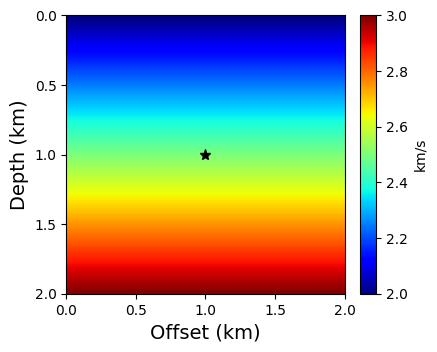

In [4]:
# Plot the velocity model with the source location
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(velmodel, extent=[x_min,x_max,z_max,z_min], aspect=1, cmap="jet")

ax.plot(source_x, source_z,'k*',markersize=8)

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('km/s',size=10)
cbar.ax.tick_params(labelsize=10)

#plt.savefig("./velmodel.pdf", format='pdf', bbox_inches="tight")
     

In [5]:
# Traveltime solution
if vertgrad==0 and horigrad==0: 
  # For homogeneous velocity model
  T_data = np.sqrt((Z-sz)**2 + (X-sx)**2)/v0;
else: 
  # For velocity gradient model
  T_data = torch.arccosh(1.0+0.5*(1.0/velmodel)*(1/v_ref)*(vertgrad**2 + horigrad**2)*((X-source_x)**2 + (Z-source_z)**2))/np.sqrt(vertgrad**2 + horigrad**2)

### Training Data Preparation
- Collocation is 25% of the grid points for training
- Creating input tensors that include spatial coordinates
- Reference traveltimes (T0) and corresponding velocities are extracted for the sampled points to serve as training targets
- Source coordinates are prepared for boundary condition enforcement

In [6]:
# Analytical solution for reference traveltime field T0
def calculate_T0(x, z, xs, zs, v_ref):
    r = torch.sqrt((x - xs)**2 + (z - zs)**2)
    return r / v_ref

T0 = calculate_T0(X, Z, source_x, source_z, v_ref)

# Sample 25% of grid points for training
num_train = int(0.25 * nx * nz)
rand_idx = torch.randperm(nx * nz)[:num_train]
train_coords = coords[rand_idx]
T0_train = T0.flatten()[rand_idx].unsqueeze(1)
velocity_train = velmodel.flatten()[rand_idx].unsqueeze(1)

# Source point coordinates (for boundary condition)
source_coords = torch.tensor([[source_x, source_z]], dtype=torch.float32, device=device)


### Neural Network Architecture (Adaptive SIREN)
Defines a custom neural network with adaptive sinusoidal activation:
- `AdaptiveActivation`: Neural network with trainable frequency parameters for each layer
- Separates adaptive parameters for specialized optimization

In [7]:
# Neural network with adaptive sinusoidal activation function
class AdaptiveActivation(nn.Module):
    def __init__(self, n_layers, n_neurons, adaptive_param=1.0):
        super(AdaptiveActivation, self).__init__()
        self.layers = nn.ModuleList()
        self.a = nn.Parameter(torch.ones(n_layers) * adaptive_param)
        
        # Input layer
        self.layers.append(nn.Linear(2, n_neurons))
        
        # Hidden layers
        for _ in range(n_layers - 1):
            self.layers.append(nn.Linear(n_neurons, n_neurons))
        
        # Output layer
        self.output = nn.Linear(n_neurons, 1)
    
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                # Adaptive sinusoidal activation
                x = torch.sin(self.a[i] * x)
        return self.output(x)

### PINN Implementation
The core Physics-Informed Neural Network class for 2D:
- `PINN`: Neural network with physics constraints
- Architecture: 8 layers with 32 neurons each, allowing the network to learn optimal activation frequencies
- `physics_loss`: Computes the factored Eikonal equation residual for 2D coordinates
- `boundary_loss`: Ensures traveltime is exactly 1.0 at the source location
- Implements gradient computation via PyTorch autograd
- Uses adaptive loss weighting with trainable λ parameters
- Uses DataLoader for batched training (batch size = 256)
- Trains for 10,000 epochs with Adam optimizer
- Includes periodic logging of loss and adaptive parameter values

In [8]:
# Physics-Informed Neural Network
class PINN:
    def __init__(self):
        self.net = AdaptiveActivation(n_layers=8, n_neurons=32).to(device)
        
        # Define lambda parameters FIRST
        self.lambda_pde = nn.Parameter(torch.tensor(1.0))
        self.lambda_bc = nn.Parameter(torch.tensor(1.0))
        
        # Separate parameters: exclude 'a' from network parameters
        net_params = []
        for name, param in self.net.named_parameters():
            if name != 'a':
                net_params.append(param)
        
        # Include lambda parameters in optimizer
        net_params.append(self.lambda_pde)
        net_params.append(self.lambda_bc)
        
        # Create optimizer with distinct parameter groups
        self.optimizer = optim.Adam([
            {'params': net_params},
            {'params': self.net.a, 'lr': 0.01}
        ], lr=0.0005)
        
        # Track loss history
        self.loss_history = []
    
    def compute_gradients(self, u, x):
        grad_u = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]
        return grad_u
    
    def physics_loss(self, coords, T0_vals, v_vals):
        coords.requires_grad_(True)
        
        # Network prediction
        u = self.net(coords)
        
        # Compute gradients
        grad_u = self.compute_gradients(u, coords)
        u_x, u_z = grad_u[:, 0:1], grad_u[:, 1:2]
        
        # Compute gradients of T0 (analytical)
        dx = coords[:, 0] - source_x
        dz = coords[:, 1] - source_z
        r = torch.sqrt(dx**2 + dz**2)
        T0_x = dx / (r * v_ref + 1e-8)
        T0_z = dz / (r * v_ref + 1e-8)
        
        # Factored Eikonal equation terms
        term_x = u * T0_x.unsqueeze(1) + T0_vals * u_x
        term_z = u * T0_z.unsqueeze(1) + T0_vals * u_z
        
        # PDE residual
        pde_residual = term_x**2 + term_z**2 - (1 / v_vals)**2
        return torch.mean(pde_residual**2)
    
    def boundary_loss(self):
        u_pred = self.net(source_coords)
        return torch.mean((u_pred - 1.0)**2)
    
    def train(self, coords, T0_vals, v_vals, epochs=10000):
        dataset = TensorDataset(coords, T0_vals, v_vals)
        dataloader = DataLoader(dataset, batch_size=256, shuffle=True)
        
        for epoch in range(epochs):
            epoch_loss = 0.0
            for batch in dataloader:
                batch_coords, batch_T0, batch_v = batch
                self.optimizer.zero_grad()
                
                # Compute losses
                loss_pde = self.physics_loss(batch_coords, batch_T0, batch_v)
                loss_bc = self.boundary_loss()
                
                # Weighted total loss
                total_loss = (self.lambda_pde.exp() * loss_pde + 
                              self.lambda_bc.exp() * loss_bc)
                
                # Backpropagation
                total_loss.backward()
                self.optimizer.step()
                
                epoch_loss += total_loss.item()
            
            # Store and print loss
            self.loss_history.append(epoch_loss / len(dataloader))
            if epoch % 1000 == 0:
                print(f"Epoch {epoch}/{epochs}, Loss: {self.loss_history[-1]:.6f}, "
                      f"λ_pde: {self.lambda_pde.exp().item():.4f}, "
                      f"λ_bc: {self.lambda_bc.exp().item():.4f}")
    
    def predict(self, coords):
        with torch.no_grad():
            return self.net(coords)



In [9]:
import time
start_time = time.time()

# Initialize and train PINN
pinn = PINN()
pinn.train(train_coords, T0_train, velocity_train, epochs=10000)

elapsed = time.time() - start_time
print('Training time: %.2f minutes' %(elapsed/60.))

Epoch 0/10000, Loss: 2.048405, λ_pde: 2.7048, λ_bc: 2.7050
Epoch 1000/10000, Loss: 0.000002, λ_pde: 2.6051, λ_bc: 2.6726
Epoch 2000/10000, Loss: 0.000005, λ_pde: 1.5963, λ_bc: 2.1539
Epoch 3000/10000, Loss: 0.000000, λ_pde: 0.2957, λ_bc: 0.5687
Epoch 4000/10000, Loss: 0.000000, λ_pde: 0.1834, λ_bc: 0.3474
Epoch 5000/10000, Loss: 0.000000, λ_pde: 0.0525, λ_bc: 0.0785
Epoch 6000/10000, Loss: 0.000000, λ_pde: 0.0255, λ_bc: 0.0229
Epoch 7000/10000, Loss: 0.000000, λ_pde: 0.0168, λ_bc: 0.0096
Epoch 8000/10000, Loss: 0.000000, λ_pde: 0.0129, λ_bc: 0.0054
Epoch 9000/10000, Loss: 0.000000, λ_pde: 0.0106, λ_bc: 0.0037
Training time: 139.50 minutes


### Domain Prediction and Visualization
Generates traveltime predictions over the entire 2D domain:
- Computes PINN `u_pred` predictions for all grid points
- Combines with reference T0 field to obtain final traveltimes

In [10]:
# Full domain prediction
with torch.no_grad():
    u_pred = pinn.predict(coords)
    T_pred = T0.flatten() * u_pred.squeeze()
    T_pred = T_pred.reshape(nx, nz).cpu().numpy()

# Calculate analytical solution (for homogeneous reference velocity)
T0_full = calculate_T0(X, Z, source_x, source_z, v_ref).cpu().numpy()

# CHANGE: Convert T_data to NumPy array
T_data_np = T_data.cpu().numpy()


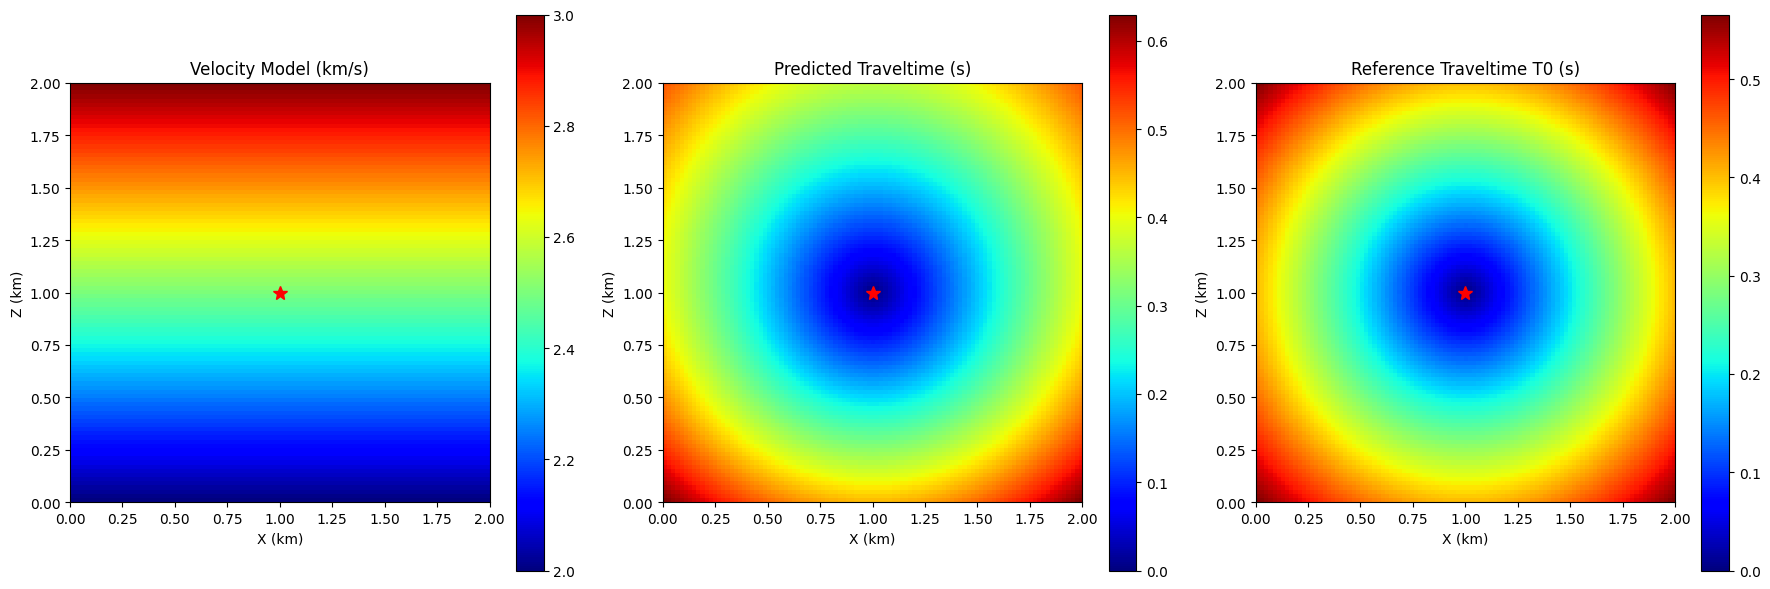

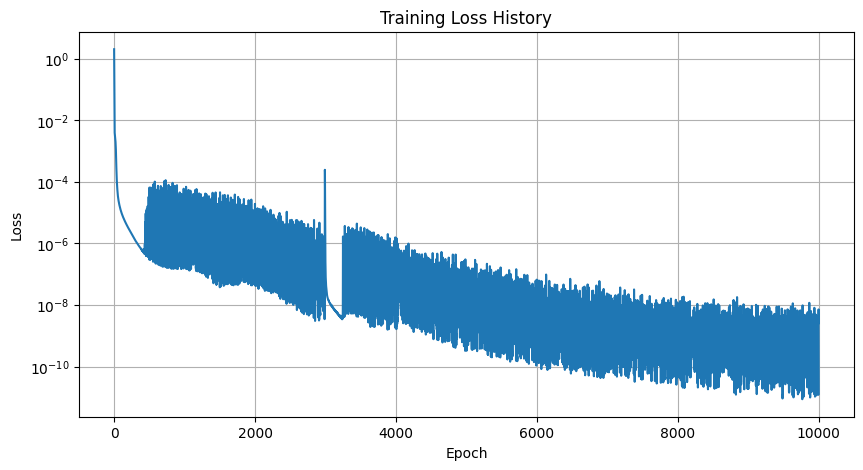

In [21]:
# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Velocity model
vel_plot = axes[0].imshow(velmodel.cpu().numpy(), origin='lower', 
                   extent=[x_min, x_max, z_min, z_max], cmap='jet')
axes[0].plot(source_x, source_z, 'r*', markersize=10)
axes[0].set_title("Velocity Model (km/s)")
plt.colorbar(vel_plot, ax=axes[0])

# Predicted traveltime
travel_plot = axes[1].imshow(T_pred, origin='lower', 
                     extent=[x_min, x_max, z_min, z_max], cmap='jet')
axes[1].plot(source_x, source_z, 'r*', markersize=10)
axes[1].set_title("Predicted Traveltime (s)")
plt.colorbar(travel_plot, ax=axes[1])

# Reference traveltime (T0)
ref_plot = axes[2].imshow(T0_full, origin='lower', 
                  extent=[x_min, x_max, z_min, z_max], cmap='jet')
axes[2].plot(source_x, source_z, 'r*', markersize=10)
axes[2].set_title("Reference Traveltime T0 (s)")
plt.colorbar(ref_plot, ax=axes[2])

# Add axis labels
for ax in axes:
    ax.set_xlabel("X (km)")
    ax.set_ylabel("Z (km)")
    ax.grid(False)

plt.tight_layout()
plt.savefig("traveltime_results.png")
plt.show()

# Plot loss history
plt.figure(figsize=(10, 5))
plt.semilogy(pinn.loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.grid(True)
plt.savefig("loss_history.png")
plt.show()

### PINN Error Analysis
Computes and visualizes the `error` between PINN predictions `T_pred` and analytical solutions `T_data_np`:
- Calculates absolute error across the domain

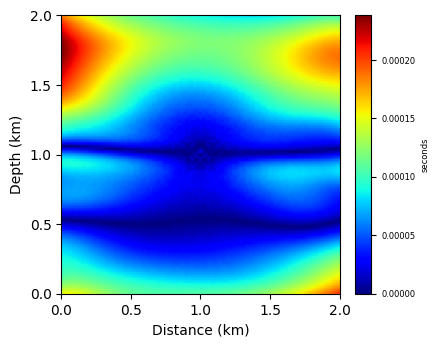

In [25]:
# Plot the PINN solution error

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
#im = ax.imshow(np.abs(T_pred-T_data), extent=[xmin,xmax,zmax,zmin], aspect=1, cmap="jet")


error = np.abs(T_pred - T_data_np) 
im = ax.imshow(
    error, 
    #origin='lower', 
    extent=[x_min, x_max, z_min, z_max],  # FIXED: Correct extent order
    aspect=1, 
    cmap="jet"
)


plt.xlabel('Distance (km)', fontsize=10)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=10)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

from mpl_toolkits.axes_grid1 import make_axes_locatable 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=6)
cbar.ax.tick_params(labelsize=6)

plt.savefig("./images/pinnerror.png", dpi=600,  format='png', bbox_inches="tight")

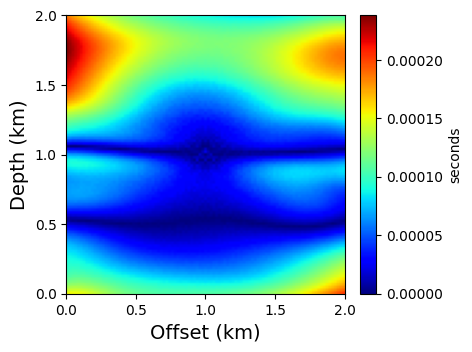

In [17]:
# Plot the PINN solution error
plt.style.use('default')
plt.figure(figsize=(4,4))

ax = plt.gca()
error_pinn = np.abs(T_pred - T_data_np)
im = ax.imshow(
    error_pinn, 
    origin='upper',  # Set origin to upper for depth display
    extent=[x_min, x_max, z_min, z_max],  # Use defined domain parameters
    aspect=1, 
    cmap="jet"
)

plt.xlabel('Offset (km)', fontsize=14)
plt.xticks(fontsize=10)
plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)
cbar.set_label('seconds', size=10)
cbar.ax.tick_params(labelsize=10)

plt.savefig("./images/pinnerror.png", dpi=600, format='png', bbox_inches="tight")
plt.show()

### Comparison with Fast Sweeping Method (FSM)
Loads and analyzes results from the Fast Sweeping Method:
- Loads pre-computed FSM traveltimes from file
- Computes the error for FSM `T_fsm` relative to analytical solution `T_data_np`

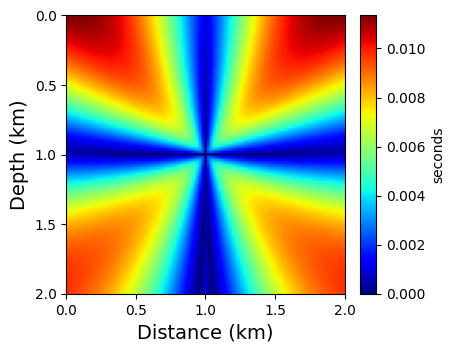

In [18]:
# Load and interpolate FSM solution
T_fsm = np.load('./traveltimes/Tcomp.npy')


# Plot the first order FSM solution error

plt.style.use('default')

plt.figure(figsize=(4,4))

ax = plt.gca()
im = ax.imshow(np.abs(T_fsm-T_data_np), extent=[x_min,x_max,z_max,z_min], aspect=1, cmap="jet")
#cmap=jet, rainbow, seismic, plasma, coolwarm

plt.xlabel('Distance (km)', fontsize=14)
plt.xticks(fontsize=10)

plt.ylabel('Depth (km)', fontsize=14)
plt.yticks(fontsize=10)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="6%", pad=0.15)

cbar = plt.colorbar(im, cax=cax)

cbar.set_label('seconds',size=10)

cbar.ax.tick_params(labelsize=10)

#plt.savefig("./fsmerror.pdf", dpi=600,  format='pdf', bbox_inches="tight")

### Multi-Method Traveltime Contour Comparison
Creates comprehensive contour plots comparing the three methods:
- Analytical solution
- PINN prediction
- Fast Sweeping Method

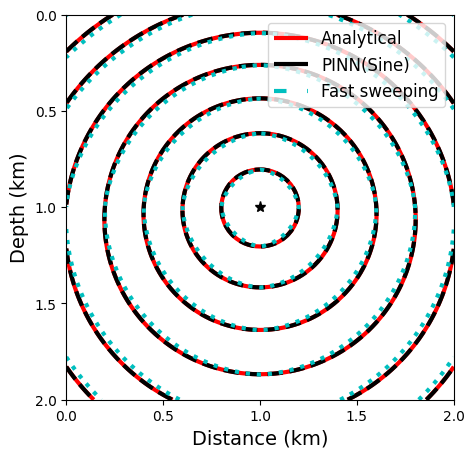

In [26]:
# Traveltime contour plots

plt.figure(figsize=(5,5))

ax = plt.gca()
im1 = ax.contour(T_data_np, 8, extent=[x_min,x_max,z_min,z_max], colors='r', linewidths = 3)
im2 = ax.contour(T_pred, 8, extent=[x_min,x_max,z_min,z_max], colors='k',linestyles = 'dashed', linewidths = 3)
im3 = ax.contour(T_fsm, 8, extent=[x_min,x_max,z_min,z_max], colors='c',linestyles = 'dotted', linewidths = 3)

ax.plot(source_x, source_z,'k*',markersize=8)

plt.xlabel('Distance (km)', fontsize=14)
plt.ylabel('Depth (km)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.gca().invert_yaxis()
h1,_ = im1.legend_elements()
h2,_ = im2.legend_elements()
h3,_ = im3.legend_elements()
ax.legend([h1[0], h2[0], h3[0]], ['Analytical', 'PINN(Sine)', 'Fast sweeping'],fontsize=12)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.5))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.savefig("./images/PINN.png", dpi=600, format='png', bbox_inches="tight")